# Discussion A - #6, week 7, 11/10/20

## Agenda


- Naive Bayes - Generative example
- Imbalanced Data Strategies

In [246]:
from sklearn import datasets, naive_bayes, metrics, preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# The digits dataset
digits = datasets.load_digits()

### What is in this dataset?

#### Features

In [4]:
digits.data.shape

(1797, 64)

In [35]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [149]:
digits.data[0].reshape(8,8)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

#### Classes

In [18]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

In [34]:
classes = [x for x in set(digits.target)]
classes.sort()
print(classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


#### Visualize some examples

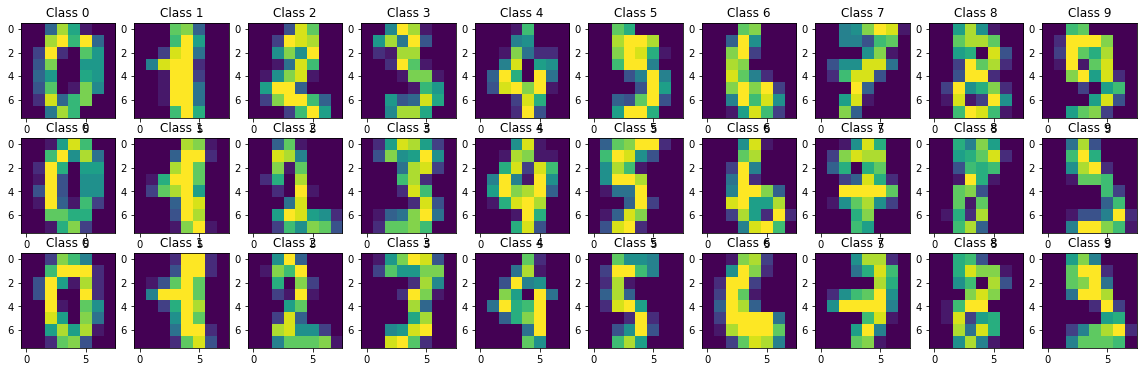

In [62]:
fig, axes = plt.subplots(3,10, figsize=(20,6))

# we don't *need* to enumerate since our classes are a numerical range
# but this is a more general approach
for i, x in enumerate(classes):
    # find an example of the class
    class_indices = np.where(digits.target == i)[0]
    
    for j in range(3):
        # grab a sample and reshape into a matrix
        image = digits.data[class_indices[j]].reshape(8,8)

        # plot the matrix
        axes[j,i].set_title(f'Class {x}')
        axes[j,i].imshow(image, interpolation='nearest')

In [106]:
train_x, test_x, train_y, test_y = train_test_split(digits.data, digits.target, test_size = 0.2, random_state=0)

scaler = preprocessing.StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

gnb = naive_bayes.GaussianNB()
gnb.fit(train_x_scaled, train_y)
gnb_predicted = gnb.predict(test_x_scaled)
print(metrics.classification_report(test_y, gnb_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.54      0.94      0.69        35
           2       1.00      0.36      0.53        36
           3       0.86      0.86      0.86        29
           4       1.00      0.53      0.70        30
           5       0.97      0.88      0.92        40
           6       0.98      1.00      0.99        44
           7       0.65      1.00      0.79        39
           8       0.48      0.59      0.53        39
           9       1.00      0.61      0.76        41

    accuracy                           0.78       360
   macro avg       0.85      0.78      0.78       360
weighted avg       0.84      0.78      0.77       360



Text(0.5, 0.98, 'Confusion Matrix')

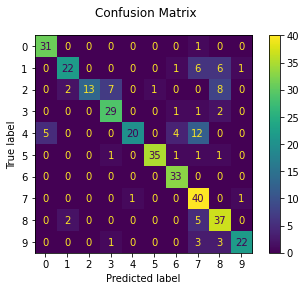

In [104]:
cm = metrics.plot_confusion_matrix(gnb, test_x_scaled, test_y)
cm.figure_.suptitle("Confusion Matrix")

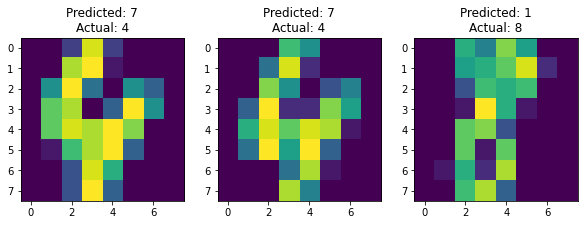

In [139]:
# show 3 confused samples
confused = np.where(gnb_predicted != test_y)[0]
fig, axes = plt.subplots(1,3, figsize=(10,3))
for i in range(3):
    image = test_x[confused[i]].reshape(8,8)
    axes[i].set_title(f'Predicted: {gnb_predicted[confused[i]]}\nActual: {test_y[confused[i]]}')
    axes[i].imshow(image, interpolation='nearest')

#### Generative

Naive Bayes learns the probability distribution for every feature.  In the digits case, this means that it has the conditional probability distribution for each pixel given a specific class.

We can extract that data back and out and verify for ourselves that, in the case of Gaussian Naive Bayes, the probability follows a normal distribution.

(array([  8.,  44., 113., 172., 212., 223., 144.,  55.,  24.,   5.]),
 array([-1.30553742, -1.07810366, -0.8506699 , -0.62323614, -0.39580238,
        -0.16836862,  0.05906514,  0.2864989 ,  0.51393265,  0.74136641,
         0.96880017]),
 <BarContainer object of 10 artists>)

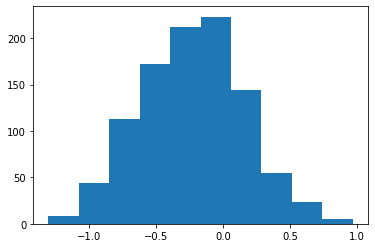

In [148]:
plt.hist(np.random.normal(gnb.theta_[0][2], gnb.sigma_[0][2],1000))

That also means that we can generate new samples from the learned probability distribution.

In the example below, we can visualize what pixels that GNB thought were most important.

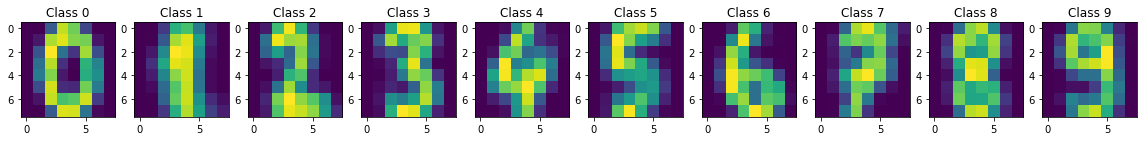

In [144]:
fig, axes = plt.subplots(1,10, figsize=(20,10))

for i,x in enumerate(classes):
    new_features = []
    for j in range(64):
        new_features.append(np.mean(np.random.normal(gnb.theta_[i][j],gnb.sigma_[i][j],10000)))

    image = scaler.inverse_transform(np.asarray(new_features)).reshape(8,8)

    # plot the matrix
    axes[i].set_title(f'Class {x}')
    axes[i].imshow(image)

### Imbalanced Data Strategies

Overview
- Over-sampling
    - draw extra samples (with replacement) for the minority class
    - create synthetic samples (eg. SMOTE, nearest neighbors)
- Under-sampling
    - discard samples from the majority class to match the minority class
- Weighting
    - weights (n_class / n_all_classes) are typically incorporated to the loss function
- Ensembles
    - bagging - many weak classifiers are trained using random samples of the data
    - boosting - iterative training of classifiers that try to minimize the error for the weakest class
 
Approach
- Reformulate the digits dataset as imblanced.
    - Map 9 => True, !9 => False
- Test over-sampling
- Test under-sampling

See also:
- https://github.com/scikit-learn-contrib/imbalanced-learn
    - implementations of many popular techniques
    - compatible with sklearn API
- sklearn classifiers that support class_weight (eg. SVC https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- sklearn classifiers that support bootstrapping (eg. RandomForest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

#### Imbalance-ization

In [247]:
train_x, test_x, train_y, test_y = train_test_split(digits.data, digits.target, test_size = 0.2)
train_x, dev_x, train_y, dev_y = train_test_split(train_x, train_y, test_size = 0.2)

scaler = preprocessing.StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
dev_x_scaled = scaler.transform(dev_x)
test_x_scaled = scaler.transform(test_x)

train_y_imbalanced = (train_y == 9).astype(int)
dev_y_imbalanced = (dev_y == 9).astype(int)
test_y_imbalanced = (test_y == 9).astype(int)

print(f'Training support: {np.unique(train_y_imbalanced, return_counts=True)}')
print(f'Development support: {np.unique(dev_y_imbalanced, return_counts=True)}')
print(f'Test support: {np.unique(test_y_imbalanced, return_counts=True)}')

Training support: (array([0, 1]), array([1029,  120], dtype=int64))
Development support: (array([0, 1]), array([259,  29], dtype=int64))
Test support: (array([0, 1]), array([329,  31], dtype=int64))


Remember to always look at your data so that you understand what you're putting into your models.  Models aren't magical, they're just math.

About 10% of samples now belong to the positive class.  This should match our expectations assuming that the digits set was originally balanced and we re-coded 1/10 of the classes to be true and all else false.

#### Baseline

The previous f1-score for the 9-class was 0.76, with an overall accuracy of 0.78.

In [241]:
gnb2 = naive_bayes.GaussianNB()
gnb2.fit(train_x_scaled, train_y_imbalanced)
gnb2_predicted = gnb2.predict(test_x_scaled)
print(metrics.classification_report(test_y_imbalanced, gnb2_predicted))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67       327
           1       0.17      1.00      0.29        33

    accuracy                           0.55       360
   macro avg       0.58      0.75      0.48       360
weighted avg       0.92      0.55      0.63       360



Good!  The class imbalance made it more difficult for our classifier to figure out what is a 9.

**Goal**: Get back to the original f1-score the 9-class.

#### Over-sampling

We will attempt different over-sampling ratios.  For example, we will re-sample our 9's up to 25% of the number of majority class from 10%.  As always though, we want to be cautious how much we manipulate our dataset from the original condition.  The further that it is engineered, the less representative of reality it becomes and may not generalize as well.

In this case I will use the development dataset since over-sampling is essentially a hyperparameter.  We will want to test the performance against an unseen dataset.

Note that we aren't modifying the test or dev sets.  Only the training set is over-sampled.  Always pretend you have minimal control over your test set since it's coming from the real world.  Also in the real world, we are less interested in results in aggregate, since each new observation is something that we need a prediction for.

In [242]:
for n in [.25, .5,1]:
    needed_samples = int(n*len(np.where(train_y_imbalanced == 0)[0])) - len(np.where(train_y_imbalanced == 1)[0])
    oversample_indices = np.random.choice(np.where(train_y_imbalanced == 1)[0], needed_samples)
    train_x_oversampled = np.append(train_x_scaled, train_x_scaled[oversample_indices],axis=0)
    gnb3 = naive_bayes.GaussianNB()
    gnb3.fit(train_x_oversampled, np.append(train_y_imbalanced,[1] * needed_samples))
    gnb3_predicted = gnb3.predict(dev_x_scaled)
    print(metrics.classification_report(dev_y_imbalanced, gnb3_predicted))

              precision    recall  f1-score   support

           0       1.00      0.55      0.71       258
           1       0.20      1.00      0.34        30

    accuracy                           0.59       288
   macro avg       0.60      0.77      0.52       288
weighted avg       0.92      0.59      0.67       288

              precision    recall  f1-score   support

           0       1.00      0.52      0.68       258
           1       0.19      1.00      0.33        30

    accuracy                           0.57       288
   macro avg       0.60      0.76      0.50       288
weighted avg       0.92      0.57      0.65       288

              precision    recall  f1-score   support

           0       1.00      0.46      0.63       258
           1       0.18      1.00      0.30        30

    accuracy                           0.52       288
   macro avg       0.59      0.73      0.47       288
weighted avg       0.91      0.52      0.60       288



None of these over-sampling ratios helped.

#### Under-sampling

This time we will randomly select a number of observations from the majority class (without replacement), such that we have the same number as the minority class.

In [243]:
needed_samples = len(np.where(train_y_imbalanced == 1)[0])
undersample_indices = np.append(np.where(train_y_imbalanced == 1)[0], np.random.choice(np.where(train_y_imbalanced == 0)[0], replace=False, size=needed_samples))
train_x_undersampled = train_x_scaled[undersample_indices]

gnb3 = naive_bayes.GaussianNB()
gnb3.fit(train_x_undersampled, train_y_imbalanced[undersample_indices])
gnb3_predicted = gnb3.predict(dev_x_scaled)
print(metrics.classification_report(dev_y_imbalanced, gnb3_predicted))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       258
           1       0.50      0.77      0.61        30

    accuracy                           0.90       288
   macro avg       0.74      0.84      0.77       288
weighted avg       0.92      0.90      0.91       288



Success!